# Phase 3: The "Future" ML Prototype (Days 15-20)
o Focus: Training the AI.

- Task: Train a Logistic Regression or XGBoost model on the Synthetic Data from Phase 1.
- Objective: Try to predict which users are "Group B" (Defaults) based only on their social
behavior.
- Explainability (Crucial for Credit):
    - Implement SHAP Values.
    - Why? You can't just tell a user "Score ALow." You must explain: "Your score is low because your profile is incomplete and you changed devices 5 times today."
- Visual Deliverable: A Streamlit dashboard showing the "Risk Distribution" of the user base.

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import xgboost as xgb

### 1. Load dataset

In [4]:
df = pd.read_excel("data/detrust_scored.xlsx")

### 2. Feature and Target

In [5]:
features = [
    'account_age_days', 'avg_response_time', 'messages_per_day',
    'consistent_logins', 'random_logins', 'changing_ip_addresses',
    'verified_email', 'complete_profile', 'spammy_chat_behavior',
    'toxic_message_count_prior', 'connects_with_other_users'
]

X = df[features]
y = df['target']  # 1 = Good, 0 = Default

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3. Train models

- Random Forest Classification

In [6]:
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_cls.fit(X_train, y_train)
y_pred_rf = rf_cls.predict(X_test)
y_prob_rf = rf_cls.predict_proba(X_test)[:, 1]

- XGB Classifier

In [7]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

### 6. Evaluate models

In [8]:
rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_rf, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test, y_prob_rf)
}

xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_test, y_pred_xgb, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_xgb, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test, y_prob_xgb)
}

In [9]:
metrics_df = pd.DataFrame([rf_metrics, xgb_metrics])
metrics_df[['Accuracy','Precision','Recall','F1-Score','ROC-AUC']] = metrics_df[
    ['Accuracy','Precision','Recall','F1-Score','ROC-AUC']].applymap(lambda x: round(x,3))
print(metrics_df)

           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Random Forest     0.919      0.919   0.919     0.919    0.919
1        XGBoost     0.920      0.920   0.920     0.920    0.919


In [10]:
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Random Forest Confusion Matrix:
 [[9195  828]
 [ 791 9186]]

XGBoost Confusion Matrix:
 [[9191  832]
 [ 774 9203]]


### 7. Feature Importance 

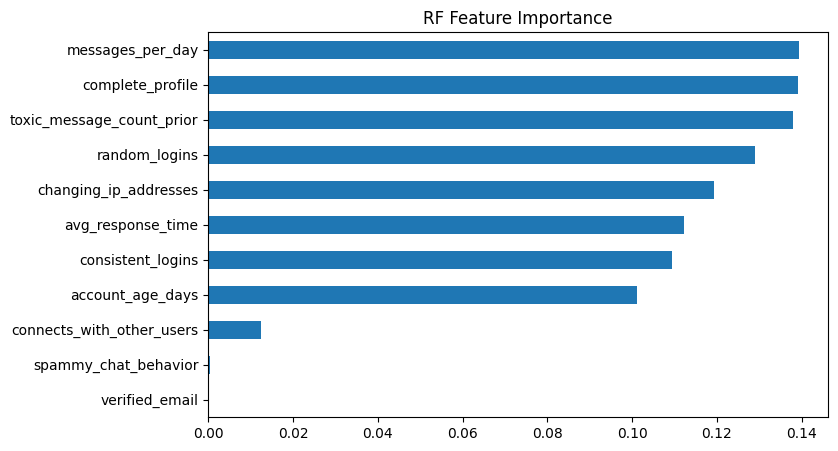

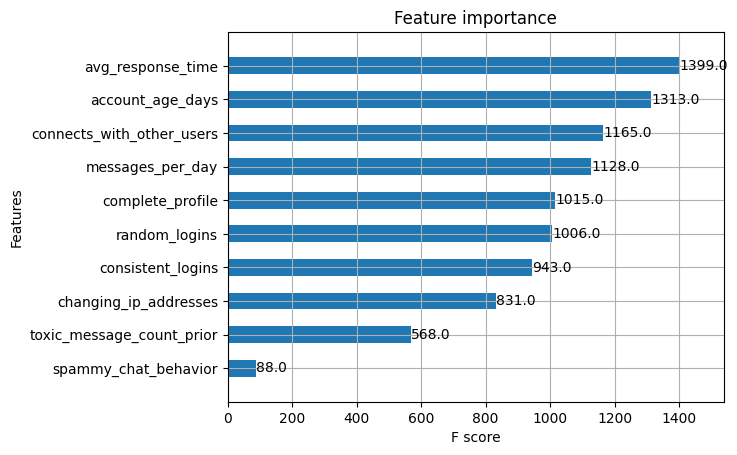

In [11]:
import matplotlib.pyplot as plt

# RF Feature Importance
feat_imp_rf = pd.Series(rf_cls.feature_importances_, index=X.columns)
feat_imp_rf.sort_values().plot(kind='barh', figsize=(8,5), title="RF Feature Importance")
plt.show()

# XGB Feature Importance
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.show()

In [12]:
import joblib
import xgboost as xgb

xgb_model.save_model("model/xgb_model.json") # XGBoost
joblib.dump(rf_cls, "model/rf_model.pkl")  # RF

['model/rf_model.pkl']

In [13]:
# %%writefile streamlit.py

In [14]:
%%writefile streamlit.py
import streamlit as st
import numpy as np
import joblib
import xgboost as xgb

# -------- Page Config --------
st.set_page_config(
    page_title="Trust Score Predictor",
    page_icon="🔍",
    layout="wide"
)

st.title("🔍 User Trust Score Predictor")
st.markdown(
    "Predict if a user is **Good (Group A)** or **Default (Group B)** "
    "and view detailed Trust Score breakdown"
)

# -------- Load Models --------
@st.cache_resource
def load_models():
    try:
        xgb_model = xgb.XGBClassifier()
        xgb_model.load_model("model/xgb_model.json")
        rf_model = joblib.load("model/rf_model.pkl")
        return xgb_model, rf_model
    except Exception as e:
        st.error(f"❌ Could not load models: {e}")
        st.stop()

xgb_model, rf_model = load_models()
model_choice = st.sidebar.selectbox("Select Model", ["XGBoost", "Random Forest"])
model = xgb_model if model_choice == "XGBoost" else rf_model

# -------- Score Functions --------
def profile_score_stability(percent):
    if percent < 30: return 0
    elif percent < 50: return 10
    elif percent < 70: return 20
    elif percent < 90: return 25
    else: return 30

def calculate_stability_score(row):
    age_score = max(0, min(row['account_age_days'] / 10, 40))
    profile_score = profile_score_stability(row['complete_profile'])
    verified_score = int(row['verified_email']) * 10
    total_logins = row['consistent_logins'] + row['random_logins']
    consistency_score = (row['consistent_logins'] / total_logins) * 20 if total_logins > 0 else 0

    breakdown = {
        "Account Age": age_score,
        "Profile Completeness": profile_score,
        "Verified Email": verified_score,
        "Login Consistency": consistency_score
    }

    return min(sum(breakdown.values()), 100), breakdown

def calculate_network_score(row):
    connections = max(0, row['connects_with_other_users'])
    account_age = max(0, row['account_age_days'])

    breakdown = {
        "Connections": min(connections * 4, 40),
        "Account Age Bonus": min(account_age / 40, 25),
        "Isolation Penalty": -(5 - connections) * 5 if connections < 5 else 0
    }

    return max(0, min(sum(breakdown.values()), 80)), breakdown

def calculate_behavior_score(row):
    avg_response = max(0, row['avg_response_time'])
    messages = max(0, row['messages_per_day'])
    toxic_count = max(0, row['toxic_message_count_prior'])
    spam_flag = int(row['spammy_chat_behavior'])

    response_score = (
        30 if avg_response <= 5 else
        25 if avg_response <= 10 else
        20 if avg_response <= 20 else
        15 if avg_response <= 30 else 10
    )

    activity_score = (
        25 if 10 <= messages <= 40 else
        20 if 5 <= messages < 10 or 40 < messages <= 60 else
        15 if messages < 5 else 10
    )

    toxicity_score = (
        25 if toxic_count == 0 else
        20 if toxic_count <= 2 else
        15 if toxic_count <= 5 else
        10 if toxic_count <= 10 else 5
    )

    breakdown = {
        "Response Time": response_score,
        "Activity": activity_score,
        "Toxicity": toxicity_score,
        "Spam Penalty": -spam_flag * 20
    }

    return max(0, min(sum(breakdown.values()), 80)), breakdown

def calculate_credit_score(row):
    stability, stab_breakdown = calculate_stability_score(row)
    network, net_breakdown = calculate_network_score(row)
    behavior, beh_breakdown = calculate_behavior_score(row)

    weighted = (
        stability * 0.3 +
        (network / 80 * 100) * 0.3 +
        (behavior / 80 * 100) * 0.4
    )

    total_score = int(300 + (weighted / 100) * 550)

    return (
        total_score,
        stability,
        network,
        behavior,
        stab_breakdown,
        net_breakdown,
        beh_breakdown
    )

def categorize_score(score):
    if score >= 800: return "Excellent"
    elif score >= 740: return "Very Good"
    elif score >= 670: return "Good"
    elif score >= 580: return "Fair"
    elif score >= 500: return "Poor"
    else: return "Very Poor"

# -------- User Inputs --------
col1, col2, col3 = st.columns(3)

with col1:
    st.subheader("🏦 Account Info")
    account_age_days = st.number_input("Account Age (days)", 0, 3650, 100)
    complete_profile = st.slider("Profile Completeness (%)", 0, 100, 75)
    verified_email = st.selectbox(
        "Verified Email", [0, 1],
        format_func=lambda x: "Yes" if x else "No"
    )

with col2:
    st.subheader("🧠 Behavior Info")
    avg_response_time = st.number_input("Avg Response Time (sec)", 0.0, 300.0, 10.0)
    messages_per_day = st.number_input("Messages per Day", 0, 500, 20)
    consistent_logins = st.number_input("Consistent Logins", 0, 1000, 50)
    random_logins = st.number_input("Random Logins", 0, 1000, 5)
    spammy_chat_behavior = st.selectbox(
        "Spammy Chat", [0, 1],
        format_func=lambda x: "Yes" if x else "No"
    )
    toxic_message_count_prior = st.number_input("Toxic Messages", 0, 100, 0)

with col3:
    st.subheader("🌐 Network Info")
    connects_with_other_users = st.number_input("Connections", 0, 500, 10)

# -------- Predict Button --------
if st.button("🔮 Predict Trust Score"):

    user_row = {
        'account_age_days': account_age_days,
        'complete_profile': complete_profile,
        'verified_email': verified_email,
        'avg_response_time': avg_response_time,
        'messages_per_day': messages_per_day,
        'consistent_logins': consistent_logins,
        'random_logins': random_logins,
        'connects_with_other_users': connects_with_other_users,
        'spammy_chat_behavior': spammy_chat_behavior,
        'toxic_message_count_prior': toxic_message_count_prior
    }

    input_data = np.array([[  # for model prediction
        account_age_days, avg_response_time, messages_per_day,
        consistent_logins, random_logins, 0,
        verified_email, complete_profile, spammy_chat_behavior,
        toxic_message_count_prior, connects_with_other_users
    ]])

    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0]

    (
        credit_score,
        stability_score,
        network_score,
        behavior_score,
        stab_breakdown,
        net_breakdown,
        beh_breakdown
    ) = calculate_credit_score(user_row)

    color = "#2ecc71" if credit_score >= 670 else "#f39c12" if credit_score >= 580 else "#e74c3c"

    st.markdown(
        f"""
        <div style='background:#111; padding:25px; border-radius:15px;
                    border-left:6px solid {color};'>
        <h2 style='color:{color};'>Trust Score: {credit_score}</h2>
        <h4>{categorize_score(credit_score)}</h4>
        <p>Prediction: {"GOOD USER ✅" if prediction == 1 else "DEFAULT USER ❌"}</p>
        <p>Good: {probability[1]*100:.1f}% | Default: {probability[0]*100:.1f}%</p>
        </div>
        """,
        unsafe_allow_html=True
    )

    # -------- Component Totals --------
    st.markdown("## Component Total Scores")
    c1, c2, c3 = st.columns(3)
    c1.metric("🏦 Stability", f"{stability_score:.1f} / 100")
    c2.metric("🌐 Network", f"{network_score:.1f} / 80")
    c3.metric("🧠 Behavior", f"{behavior_score:.1f} / 80")

    total_component_score = stability_score + network_score + behavior_score
    st.markdown(f"### 🏆 Total Component Score: {total_component_score:.1f}")
    
    # -------- Feature Contributions --------
    st.markdown("## ➕➖ Feature Contribution (Why Score Changes)")

    def render_features(title, breakdown):
        st.subheader(title)
        items = list(breakdown.items())
        for i in range(0, len(items), 3):
            cols = st.columns(3)
            for col, (name, value) in zip(cols, items[i:i+3]):
                sign = "+" if value >= 0 else ""
                color = "#2ecc71" if value >= 0 else "#e74c3c"
                col.markdown(
                    f"<span style='color:{color}; font-size:17px;'>"
                    f"{name}<br>{sign}{value:.1f}</span>",
                    unsafe_allow_html=True
                )

    render_features("🏦 Stability Factors", stab_breakdown)
    render_features("🌐 Network Factors", net_breakdown)
    render_features("🧠 Behavior Factors", beh_breakdown)

Overwriting streamlit.py


In [ ]:
!streamlit run streamlit.py